In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set directory
os.chdir('C:\\Users\\manch_000\\Desktop\\Self-Driving Cars ND\\CarND-LaneLines-P1')
%matplotlib inline

In [2]:
link_1 = 'test_images\\solidWhiteRight.jpg'
link_2 = 'test_images\\solidWhiteCurve.jpg'
link_3 = 'test_images\\solidYellowCurve.jpg'
link_4 = 'test_images\\solidYellowCurve2.jpg'
link_5 = 'test_images\\solidYellowLeft.jpg'
link_6 = 'test_images\\whiteCarLaneSwitch.jpg'
links = [link_1, link_2, link_3, link_4, link_5, link_6]
#reading in images
def read_images(link):
    image = mpimg.imread(link)
    
    return image

#printing out some stats and plotting
def plot_image(image):
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)


In [3]:
low_threshold = 50
high_threshold = 150
kernel_size = 5
vertices = np.array([[(100,540),(460, 320), (510, 320), (900,540)]], dtype=np.int32)
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
# line_image = np.copy(image)*0 # creating a blank to draw lines on


In [4]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    
    conv_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    return conv_gray

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    
    gaus_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
    return gaus_img

def canny(img, low_threshold, high_threshold):
    can_image = cv2.Canny(img, low_threshold, high_threshold)
    
    return can_image

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    final = separate_lines(lines)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, final, color=[255, 0, 0], thickness=15)
    
    return line_img

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
#    lines_h = cv2.HoughLinesP(region_of_interest(canny(gaussian_blur(grayscale(read_images(image)), kernel_size), low_threshold, high_threshold), vertices), rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)
#    lines = np.zeros((540, 960, 3), dtype=np.uint8)
#    final = separate_lines(lines_h)
#    line_image = np.copy(img)*0 # creating a blank to draw lines on
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    
    
    return cv2.addWeighted(initial_img, α, img, β, λ)

def separate_lines(lines):
    
    right_lines = []
    left_lines = []
    bad_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            line_slope = (y2 - y1)/(x2 - x1)
            if line_slope > 0:
                left_lines.append(line)
            elif line_slope < 0:
                right_lines.append(line)
            else:
                bad_lines.append(line)
    
    l_line = average_line(left_lines)
    r_line = average_line(right_lines)
    
    return [r_line, l_line]

# right_line, left_line = separate_lines(lines)

def average_line(l_lines):
    
    
    p_1 = 0
    p_2 = 0
    # l_lines is a list of lines belong to one lane line
    length_l = len(l_lines)
    if length_l == 0:
        length_l = 1 # in case no lines are detected
    for line in l_lines:
        for x1,y1,x2,y2 in line:
            fitted_line = np.polyfit([x1, x2], [y1, y2], 1) #  Returns a vector of coefficients p that minimises the squared error.
            p_1 = p_1 + (fitted_line[0] / length_l)
            p_2 = p_2 + (fitted_line[1] / length_l)
    
    # Find the length of lane lines to be drawn
    min_y = 540
    min_x = int((540 - p_2) / p_1)
    max_y = 330
    max_x = int((max_y - p_2) / p_1) - 2
    
    line_array = np.array([[max_x, max_y, min_x, min_y]])
    
    return line_array


In [7]:
def process_image(image):
    
#    read_images(image)
    gray = grayscale(read_images(image))
    blur = gaussian_blur(gray, kernel_size)
    edges = canny(blur, low_threshold, high_threshold)
    mask = region_of_interest(edges, vertices)
    line_im = hough_lines(mask, rho, theta, threshold, min_line_length, max_line_gap)
    result = weighted_img(line_im, read_images(image), α=0.8, β=1., λ=0.)
#    lines_h = cv2.HoughLinesP(region_of_interest(canny(gaussian_blur(grayscale(read_images(image)), kernel_size), low_threshold, high_threshold), vertices), rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)
#    lines = np.zeros((540, 960, 3), dtype=np.uint8)
#    final = separate_lines(lines_h)
#    draw_lines(lines, final, color=[255, 0, 0], thickness=10)
#    lines_on_image = weighted_img(lines, read_images(image))
    
    return result

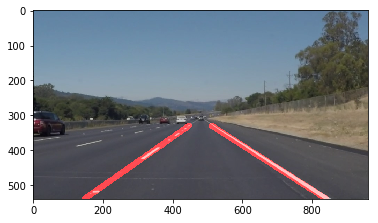

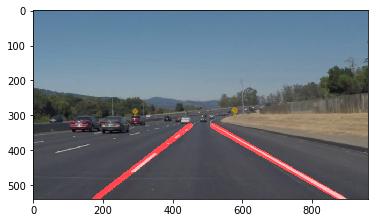

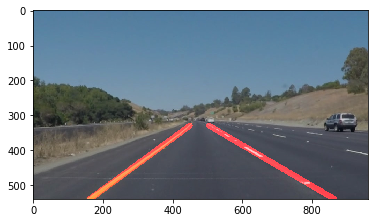

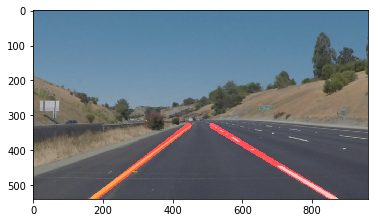

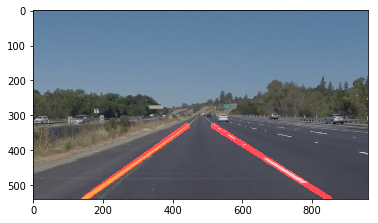

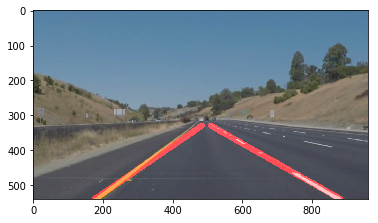

In [8]:
for img in links:
    process_image(img)
    plt.figure()
    plt.imshow(process_image(img))

In [9]:
white_output = 'solidYellowLeftTest.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('test_videos\\solidYellowLeft.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

TypeError: Object does not appear to be a 8-bit string path or a Python file-like object